<a href="https://colab.research.google.com/github/onishchenkoar/dungeons-and-dragons-and-probabilities/blob/main/All_Rolls_TalDorei_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# All Rolls Tal'Dorei: Exploratory Data Analysis

## Introduction

[*Critical Role*](https://en.wikipedia.org/wiki/Critical_Role) is "a show where a bunch of nerdy-ass voice actors play [*Dungeons and Dragons*](https://en.wikipedia.org/wiki/Dungeons_%26_Dragons)". CritRoleStats is a group of enthusiasts from the community that track and analyze different events of the game. In this project, I am going to explore their [*All Rolls - Tal'Dorei*](https://docs.google.com/spreadsheets/d/1OEg29XbL_YpO0m5JrLQpOPYTnxVsIg8iP67EYUrtRJg/edit?usp=sharing) table &mdash; a table of dice rolls for the whole Tal'Dorei campaign.

Note: I already have quite a bit of familiarity with the data because a) I am a fan of the show, b) I've spent a long time cleaning up the table as a part of this project. Code for the cleanup can be viewed [here](https://nbviewer.jupyter.org/github/onishchenkoar/dungeons-and-dragons-and-probabilities/blob/main/Cleanup_All_Rolls_TalDorei.ipynb) and can be downloaded [here](https://github.com/onishchenkoar/dungeons-and-dragons-and-probabilities/blob/main/Cleanup_All_Rolls_TalDorei.ipynb). The cleaned-up table is [here](https://github.com/onishchenkoar/dungeons-and-dragons-and-probabilities/blob/main/Cleanup_All_Rolls_TalDorei/Cleanish_All_Rolls_TalDorei.xlsx).

## Imports

In [51]:
from google.colab import drive
drive.mount('/content/drive')

from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns


sns.set()
pd.set_option('display.max_rows', 15000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', 500)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Initializing a DataFrame

In [72]:
df = pd.read_excel('drive/MyDrive/Cleanish_All_Rolls_TalDorei.xlsx'
                   , sheet_name='All Episodes')

# Make uncertain rolls certain; replace rolls for fun with 'Other'.
df['Type of Roll'].replace({'Alchemy?' : 'Alchemy',
                            'Arcana?' : 'Arcana',
                            'Athletics/Acrobatics' : 'Athletics',                           
                            'Persuasion?' : 'Persuasion',
                            'Wisdom Save?' : 'Wisdom Save',

                            'Disappointment' : 'Other',
                            'Panic' : 'Other',
                            'Test Roll' : 'Other',                           
                            'Trajectory' : 'Other',
                            'Unknown' : 'Other',
                            np.nan : 'Other',
                            }
                           , inplace=True
                          )

df['Total Value'] = df['Total Value'].fillna('Unknown')
df['Natural Value'] = df['Natural Value'].fillna('Unknown')
df['Character'] = df['Character'].fillna('Other')

## Overview

Columns:
1. **Episode** &mdash; id of an episode in which a roll happens. Categorical.
1. **Time** &mdash; timestamp of the roll. Continuous; represented as a string 'HH:MM:SS'.
1. **Character** &mdash; in-game name of the character who makes the roll. Categorical.
1. **Type of Roll** &mdash; an action on which a random decision is needed. For example, Attack, Persuasion, or Deception. Categorical.
1. **Total Value** &mdash; Natural Value + all bonuses the character has during the action. Mixed type: continuous values when known, empty or 'Unknown' otherwise. 
1. **Natural Value** &mdash; a value given by the dice. In a d20 (20-sided die) roll, often, 20 means automatic success, 1 means automatic failure (regardless of the total value). Mixed type: continuous values when known, empty or 'Unknown' otherwise. 
1. **Crit?** &mdash; whether a critical hit rolled (natural 20 on an Attack roll). Categorical: either 'Y' or empty.
1. **Damage** &mdash; value of damage of an attack and its target's name. I think these should be in two separate columns, but I prefer to just ignore this column. Mixed type.
1. **# Kills** &mdash; number of targets killed by an attack. Continuous.
1. **Notes** &mdash; some information about the roll.

In [73]:
df.dtypes

Episode           object
Time              object
Character         object
Type of Roll      object
Total Value       object
Natural Value     object
Crit?             object
Damage            object
# Kills          float64
Notes             object
dtype: object

In [74]:
df.head()

,Episode,Time,Character,Type of Roll,Total Value,Natural Value,Crit?,Damage,# Kills,Notes
0,C1E001,0:37:53,Vex'ahlia,Intelligence,20,18,NaN,NaN,NaN,FIRST ROLL OMG
1,C1E001,0:41:48,Grog,Persuasion,19,18,NaN,NaN,NaN,NaN
2,C1E001,0:43:25,Keyleth,Persuasion,2,2,NaN,NaN,NaN,NaN
3,C1E001,0:46:35,Tiberius,Persuasion,12,3,NaN,NaN,NaN,Disregarded due to advantage
4,C1E001,0:46:35,Tiberius,Persuasion,27,18,NaN,NaN,NaN,With advantage


## Simple descriptive statistics

In [75]:
print(f'Total rows: {len(df)}\n')
df.drop('# Kills', axis=1).describe()

Total rows: 13433



,Episode,Time,Character,Type of Roll,Total Value,Natural Value,Crit?,Damage,Notes
count,13433,13433,13433,13433,13433,13433,308,2651,6940
unique,117,7597,28,69,102,23,1,2408,2163
top,C1E114,2:14:30,Vax'ildan,Attack,Unknown,Unknown,Y,6 to Kern,Disregarded due to advantage
freq,334,16,2478,3125,1918,4580,308,13,1001


You can make several conclusions from this:
1. The most action-packed episode is 114 &mdash; this is the fight with the final boss.
2. The most active character in the campaign is Vax'ildan.
3. Attack is the most popular type of roll.
4. A lot of roll values are unknown.

In [77]:
df['# Kills'].describe()

count    339.000000
mean       1.339233
std        1.952080
min        0.500000
25%        1.000000
50%        1.000000
75%        1.000000
max       30.000000
Name: # Kills, dtype: float64

The majority of attacks kill just one target.

## d20 rolls

### Preparing the dataframe

I'm only interested in d20 rolls made by the cast. Since Laura and Sam roll for two characters, I am adding a column with players' names. I'm also filtering out invalid values seen in Natural Value column.

In [5]:
df['Natural Value'].unique()

array(['18', '2', '3', '15', '17', '6', '7', '8', '12', '13', '1',
       'Unknown', '4', nan, '20', '10', '16', '14', '11', '9', '19', '5',
       '24', '25'], dtype=object)

In [6]:
# Characters of the main cast:
CHAR_LIST = ["Keyleth", "Vax'ildan", "Vex'ahlia", "Trinket", "Grog",
             "Pike", "Percy", "Scanlan", "Taryon", "Tiberius",
             ]

# Type of Roll to filter out:
NON_D20_TYPES = [
  'Sleep Arrow', 'Other', 'Determine Effect', 'Damage',
  'Healing', 'Inspiration', "Heroes' Feast", 'Bless',
  'Potion Duration', 'Recharge', 'Beard Check', 'Parry',
  'Percentile', 'Second Wind', 'Divine Intervention',
  'Missile Snare', 'Gambit of Ord'
]

# Weird values in Natural Value column:
NATVAL_ERRS = [
  '0', '-1', '-4'
  '21', '22', '23', '24', '25', '26',
]

d20rolls = df[
   # Exclude weird values in Natural Value           
   ~df['Natural Value'].isin(NATVAL_ERRS)
   # Exclude non-d20 rolls 
   & ~df['Type of Roll'].isin(NON_D20_TYPES)
   # Filter for regular players' characters
   & df['Character'].isin(CHAR_LIST)
].copy()

d20rolls['ones'] = 1

# Replace character names with player names (some players have 2 characters):
d20rolls['Player'] = (d20rolls['Character']
                      .replace({"Keyleth" : "Marisha",
                                "Vax'ildan" : "Liam",
                                "Grog" : "Travis",
                                "Pike" : "Ashley",
                                "Percy" : "Taliesin",
                                "Tiberius" : "Orion",
                                "Scanlan" : "Sam",
                                "Taryon" : "Sam",
                                "Vex'ahlia" : "Laura",
                                "Trinket" : "Laura",
                                }
                              )
                      )
                               
mask_disadv = d20rolls['Notes'].str.contains('isadvantage').fillna(False)
mask_adv = (d20rolls['Notes'].str.contains('dvantage').fillna(False)
            & ~mask_disadv
           )
mask_resolve = d20rolls['Notes'].str.contains('esolve').fillna(False)
mask_luck = d20rolls['Notes'].str.contains('Luck').fillna(False)
mask_indomitable = d20rolls['Notes'].str.contains('ndomitable')
mask_straight = ~(mask_adv 
                  | mask_disadv 
                  | mask_resolve 
                  | mask_luck 
                  | mask_indomitable
                 )

mask_disregard = d20rolls['Notes'].str.contains('isregard').fillna(False)
mask_disregard_adv = mask_adv & mask_disregard
mask_disregard_disadv = mask_disadv & mask_disregard
# mask_crit = d20rolls['Total Value'].str.contains('Nat20')
# mask_fail = d20rolls['Total Value'].str.contains('Nat1')
mask_crit = d20rolls['Natural Value'] == '20'
mask_fail = d20rolls['Natural Value'] == '1'
mask_crit_reg = mask_crit & ~mask_disregard
mask_fail_reg = mask_fail & ~mask_disregard

print(f'All d20 rolls: {len(d20rolls)}')
print(f'Adv. disregarded: {mask_disregard_adv.sum()}')
print(f'Disadv. disregarded: {mask_disregard_disadv.sum()}')
print(f'd20 regarded: {len(d20rolls) - mask_disregard.sum()}')
print(f'Nat20 total: {mask_crit.sum()}')
print(f'Nat20 regarded: {mask_crit_reg.sum()}')
print(f'Nat1 total: {mask_fail.sum()}')
print(f'Nat1 regarded: {mask_fail_reg.sum()}')
print()
mask_crit_straight = mask_crit & mask_straight
mask_fail_straight = mask_fail & mask_straight

print('Nat20 percentage')
print((d20rolls.loc[mask_crit_straight, 'Player'].value_counts()
       / d20rolls.loc[mask_straight, 'Player'].value_counts()
      ).sort_values()
     )
print('\nNat1 percentage')

(d20rolls.loc[mask_fail_straight, 'Player'].value_counts()
 / d20rolls.loc[mask_straight, 'Player'].value_counts()
).sort_values()

All d20 rolls: 10376
Adv. disregarded: 1001
Disadv. disregarded: 355
d20 regarded: 8854
Nat20 total: 580
Nat20 regarded: 551
Nat1 total: 375
Nat1 regarded: 326

Nat20 percentage
Marisha     0.048165
Sam         0.055490
Travis      0.059104
Laura       0.059310
Orion       0.064516
Ashley      0.065574
Liam        0.066522
Taliesin    0.072131
Name: Player, dtype: float64

Nat1 percentage


Liam        0.028923
Ashley      0.030055
Orion       0.032258
Sam         0.036600
Taliesin    0.036885
Travis      0.042898
Marisha     0.050459
Laura       0.051724
Name: Player, dtype: float64

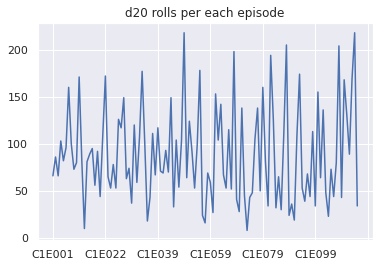

In [7]:
d20rolls['Episode'].value_counts().sort_index().plot(title='d20 rolls per each episode')
plt.show()

In [8]:
action = (d20rolls['Episode'].replace('C1E033 p2', 'C1E033')
                    .replace('C1E033 p1', 'C1E033')
                    .replace('C1E035 p1', 'C1E035')
                    .replace('C1E035 p2', 'C1E035')
                    .replace('C1E031 p1', 'C1E031')
                    .replace('C1E031 p2', 'C1E031')
                    .value_counts()
)

print(action.head())
print(action.tail())

C1E049    218
C1E114    218
C1E088    205
C1E108    204
C1E068    198
Name: Episode, dtype: int64
C1E104    23
C1E091    19
C1E057    16
C1E014    10
C1E073     8
Name: Episode, dtype: int64


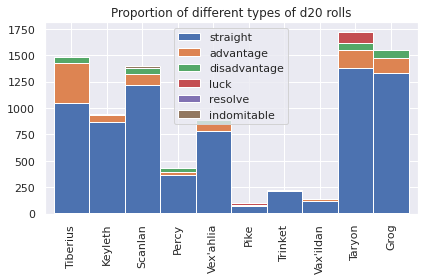

In [9]:
regarded = d20rolls.loc[~mask_disregard, 'Character'].value_counts()
straight = d20rolls.loc[mask_straight, 'Character'].value_counts()
adv = d20rolls.loc[mask_adv & ~mask_disregard, 'Character'].value_counts()
disadv = d20rolls.loc[mask_disadv & ~mask_disregard, 'Character'].value_counts()
indomitable = d20rolls.loc[mask_indomitable & ~mask_disregard, 'Character'].value_counts()
resolve = d20rolls.loc[mask_resolve & ~mask_disregard, 'Character'].value_counts()
luck = d20rolls.loc[mask_luck & ~mask_disregard, 'Character'].value_counts()
rolls_abs = pd.DataFrame({
    'straight' : straight,
    'advantage' : adv,
    'disadvantage' : disadv,
    'luck' : luck,
    'resolve' : resolve,
    'indomitable' : indomitable,
})

rolls_rel = rolls_abs.div(regarded, axis=0)
rolls_abs.plot.bar(stacked=True, width=1)
(straight / regarded).sort_values(ascending=False).plot(kind='bar', width=1, title='Proportion of different types of d20 rolls')
plt.tight_layout()
plt.savefig('proportion_of_straight_rolls.png')

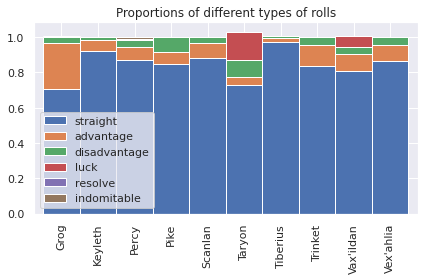

In [10]:
ax = rolls_rel.plot.bar(stacked=True, width=1, title='Proportions of different types of rolls')
plt.tight_layout()
plt.savefig('proportions_diff_rolls.png')

Numbers for players' attendance are taken from [here](https://docs.google.com/spreadsheets/d/1Zx1N0cQcd1fJadUwar7f2hJ2p61qoX7lctsVaIEa5uM/edit#gid=744793917).

In [11]:
attendance = pd.Series({'Grog' : 109,
                        'Keyleth' : 112,
                        'Percy' : 111,
                        'Pike' : 54,
                        'Scanlan' : 92,
                        'Taryon' : 14,
                        'Trinket' : 47,
                        "Vax'ildan" : 111,
                        "Vex'ahlia" : 112
                        }
                       )
coef = 114 / attendance

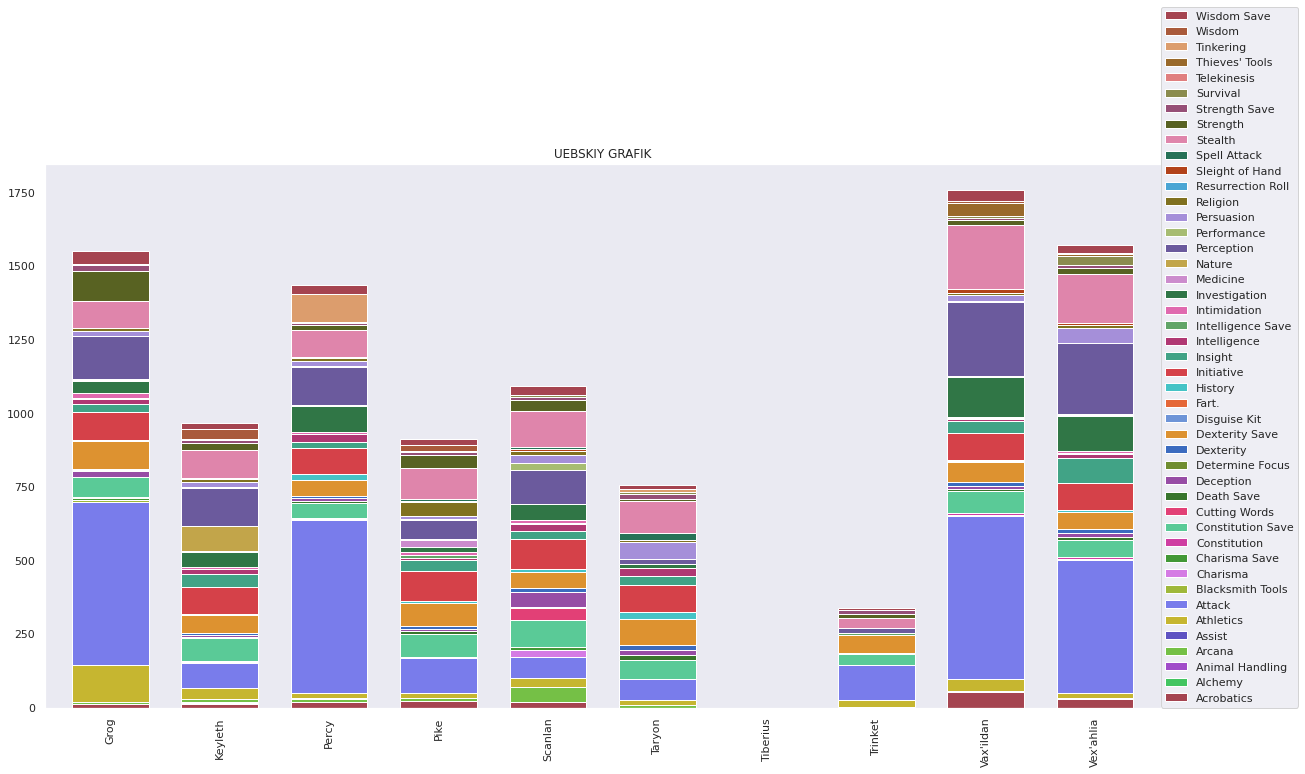

In [12]:
palette = [ 
           "#a54450", "#43c561", "#a14cc9", "#75c046", "#5f53c2", "#c6b630",
           "#797ceb", "#9fb83a", "#d57be4", "#429836", "#cf3ea2", "#5aca97",
           "#e24076", "#38752c", "#974da5", "#708e30", "#3b6bbf", "#dd9230",
           "#6e94d7", "#e56737", "#45c3c6", "#d54149", "#41a386", "#b03873",
           "#61a567", "#e06aaf", "#307646", "#cc8ccd", "#c2a54a", "#6b5a9d",
           "#a7bc72", "#a58fd9", "#807120", "#4aa5d4", "#b2421a", "#277257",
           "#df85ab", "#586222", "#964f77", "#8b8c4e", "#e07f7f", "#99692b", 
           "#dc9d6d", "#a95a3b"
]

rolls_by_char = (d20rolls.loc[~mask_disregard]
                 .pivot_table(index='Character'
                              , columns='Type of Roll'
                              , values='ones'
                              , aggfunc='sum'
                             )
                 .fillna(0)
)

ax = rolls_by_char.mul(coef, axis=0).plot.bar(figsize=(20, 10)
                                  , stacked=True
                                  , title='UEBSKIY GRAFIK'
                                  , color=palette
                                  , width=0.7
                                  , grid=False
                                 )
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc=(1, 0))
plt.savefig('d20rolls_by_char.png')

In [13]:
saves_by_char = rolls_by_char[[col for col in rolls_by_char.columns if 'Save' in col]]
ability_checks_by_char = rolls_by_char[['Strength', 'Dexterity', 'Constitution',
                                        'Wisdom', 'Charisma', 'Intelligence']]
skill_checks_by_char = rolls_by_char[['Acrobatics', 'Animal Handling', 'Arcana',
                                      'Athletics', 'Deception', 'History',
                                      'Insight', 'Intimidation', 'Investigation',
                                      'Medicine', 'Nature', 'Perception',
                                      'Performance', 'Persuasion', 'Religion',
                                      'Sleight of Hand', 'Stealth', 'Survival',
                                      ]
                                     ]

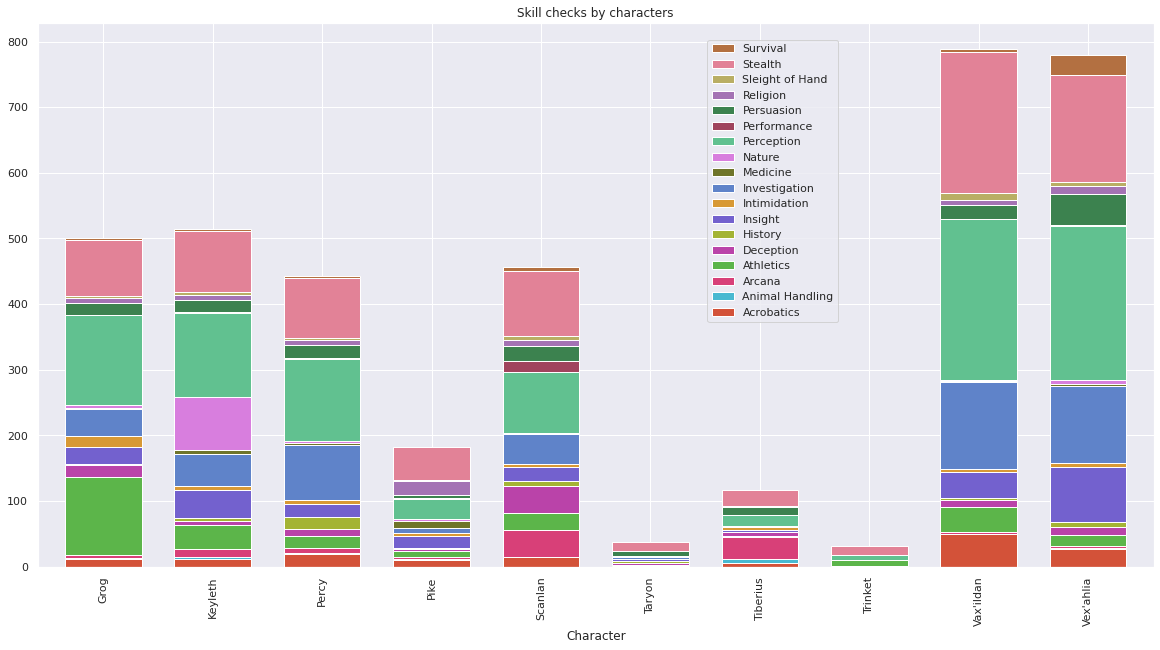

In [14]:
palette = ["#d35239", "#49b9d1", "#d84078", "#5cb54a", "#ba43a9", "#a4b434",
           "#7361ce", "#d89935", "#5f83c9", "#6f752a", "#d87ede", "#61c190",
          "#a0445d",  "#3c824f", "#a473b4", "#b9ae64", "#e28297", "#b37041"
]

ax = skill_checks_by_char.plot.bar(figsize=(20, 10)
                                  , stacked=True
                                  , title='Skill checks by characters'
                                  , color=palette
                                  , width=0.7
                                 )
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc=(0.6, 0.45))
plt.savefig('skill_checks.png')

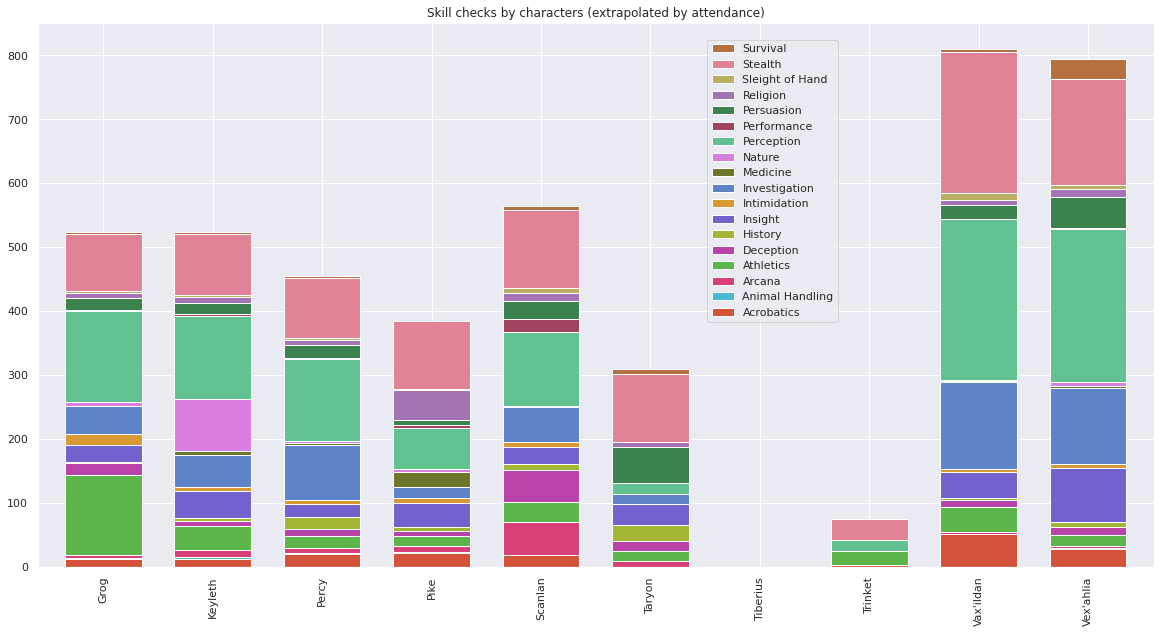

In [15]:
ax = skill_checks_by_char.mul(coef, axis=0).plot.bar(figsize=(20, 10)
                                            , stacked=True
                                            , title='Skill checks by characters (extrapolated by attendance)'
                                            , color=palette
                                            , width=0.7
                                          )
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc=(0.6, 0.45))
plt.savefig('skill_checks_projection.png')

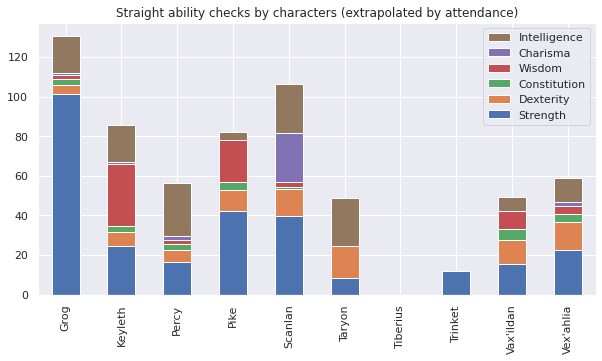

In [16]:
ax = ability_checks_by_char.mul(coef, axis=0).plot.bar(figsize=(10, 5)
                                            , stacked=True
                                            , title='Straight ability checks by characters (extrapolated by attendance)'
                                            #, width=0.7
                                            #, color=palette
                                          )
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.savefig('ability_checks_projection.png')

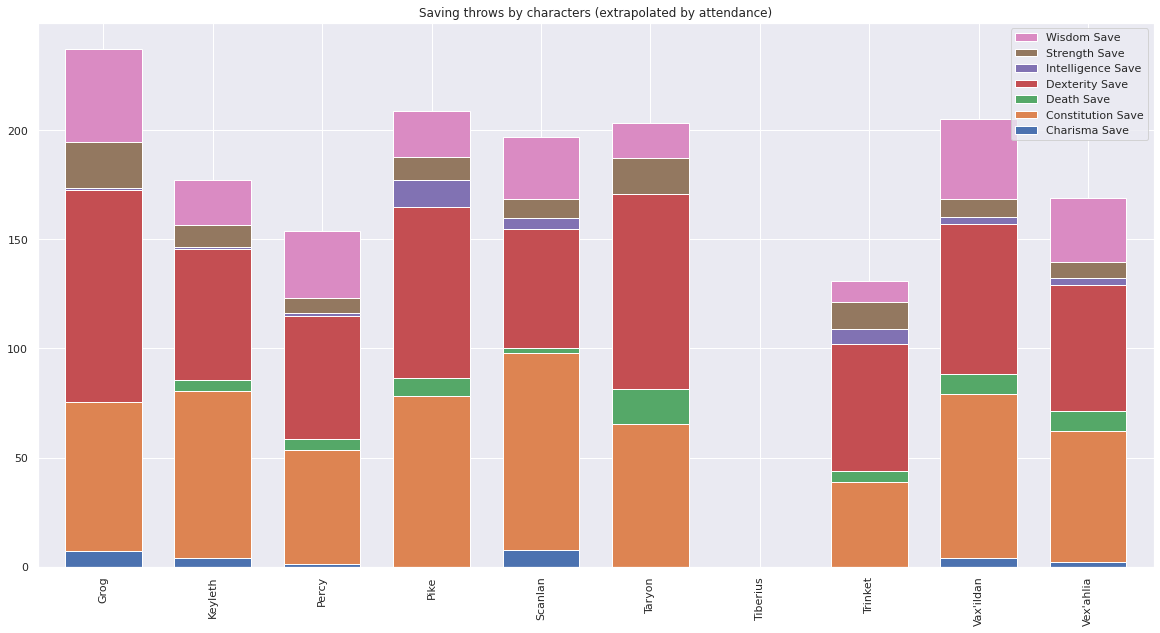

In [17]:
ax = (saves_by_char.mul(coef, axis=0)
                   .plot.bar(figsize=(20, 10)
                             , stacked=True
                             , title='Saving throws by characters (extrapolated by attendance)'
                             , width=0.7
                            )
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.savefig('saves_projection.png')

### Naive d20 rolls

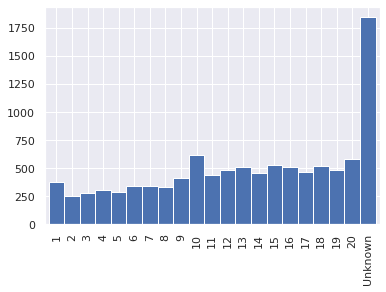

In [18]:
d20rolls['Natural Value'].value_counts()[[str(i) for i in range(1, 21)] + ['Unknown']].plot.bar(width=1)

### Straight d20 rolls

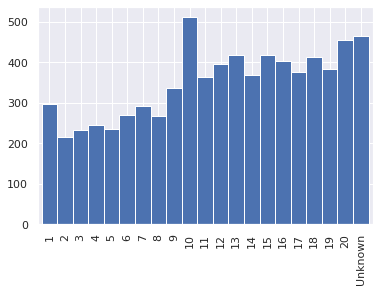

In [19]:
d20rolls.loc[mask_straight, 'Natural Value'].value_counts()[[str(i) for i in range(1, 21)] + ['Unknown']].plot.bar(width=1)

### Straight d20 with *Unknown* removed

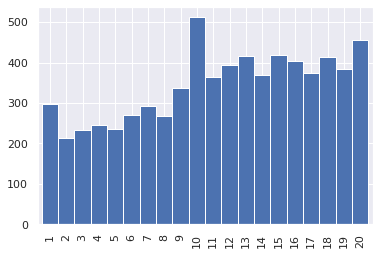

In [20]:
d20rolls.loc[mask_straight & (d20rolls['Natural Value'] != 'Unknown').fillna(False), 'Natural Value'].dropna().astype(int).value_counts().sort_index().plot.bar(width=1)

### Straight rolls with *Unknown* and rolls subject to Reliable Talent removed

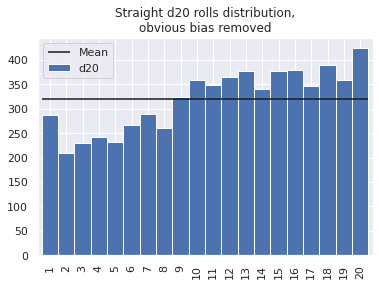

In [21]:
is_after_ep19 = (d20rolls['Episode']
                 .isin(['C1E%03d' % i for i in range(20, 116)] 
                        + ['C1E031 p1', 'C1E031 p2', 
                            'C1E033 p1', 'C1E033 p2',
                            'C1E035 p1', 'C1E031 p2',
                          ]
                      )
)
is_vaxildan_proficient = (d20rolls['Type of Roll']
                          .isin(['Acrobatics', 'Intimidation',
                                 'Investigation', 'Perception',
                                 'Persuasion', 'Sleight of Hand',
                                 'Stealth'
                                ]
                               )
)                 
is_reliable_talent = ((d20rolls['Character'] == "Vax'ildan")
                      & is_after_ep19
                      & is_vaxildan_proficient
)
is_natval_known = ((d20rolls['Natural Value'] != 'Unknown')
                   & d20rolls['Natural Value'].notna()
)
counts = (d20rolls.loc[mask_straight
                       & ~is_reliable_talent
                       & is_natval_known
                       , 'Natural Value'
                      ].astype(int)
                       .value_counts()
)
(counts.sort_index() # [[str(i) for i in range(1, 21)] + ['Unknown']]
       .plot(kind='bar'
             , title='Straight d20 rolls distribution,\nobvious bias removed'
             , width=1
             , label='d20'
            )
)

plt.hlines(counts.mean(), -0.5, 19.5, label='Mean')
plt.legend()
plt.savefig('obvious_bias_removed.png')

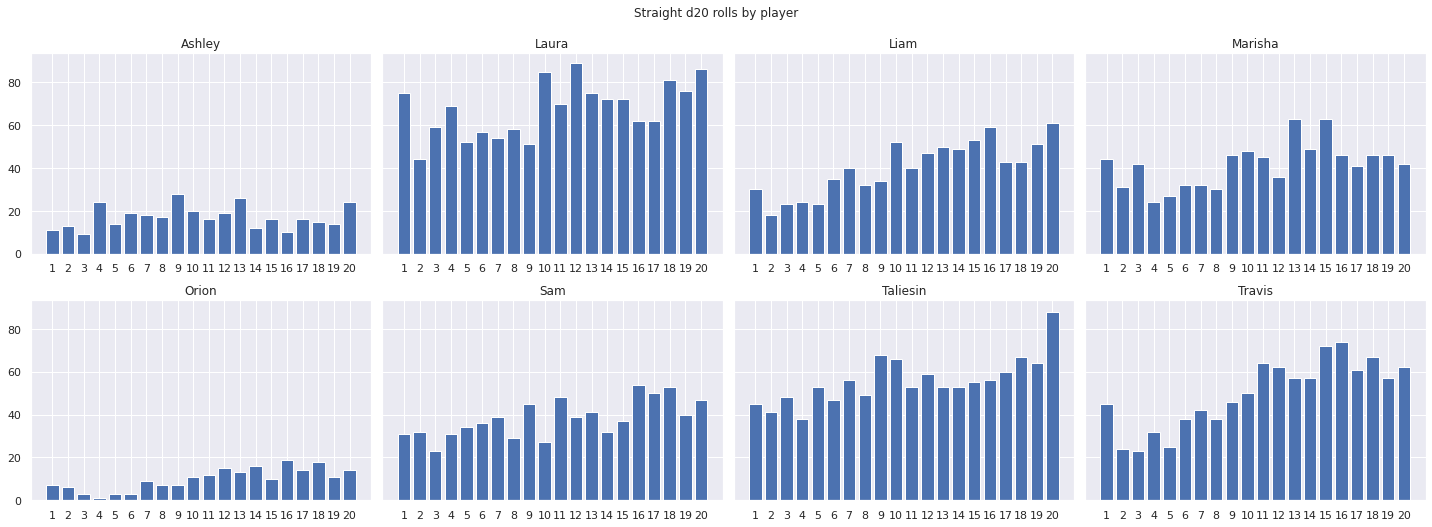

In [37]:
import scipy.stats as ss

players = sorted(d20rolls['Player'].unique())
samples = {player : d20rolls.loc[mask_straight
                                 & is_natval_known
                                 & ~is_reliable_talent
                                 & (d20rolls['Player'] == player)
                                 , 'Natural Value'
                                ].astype(int).value_counts().sort_index()
           for player in players
}
#print(ss.f_oneway(*list(samples.values())))
fig, axs = plt.subplots(nrows=2,
                        ncols=4,
                        figsize=(20, 7),
                        #sharex=True,
                        sharey=True
                        )
axs = axs.flatten()
for i, (player, ax) in enumerate(zip(players, axs)):
  counts = samples[player]
  ax.bar(counts.index, counts.values)
  ax.set_title(player)
  ax.set_xticks(np.arange(1, 21))
  if i > len(players):
    ax.remove()
plt.xticks(np.arange(1, 21))
fig.suptitle('Straight d20 rolls by player', y=1.04)
plt.tight_layout()
plt.savefig('straight_d20_by_player.png')

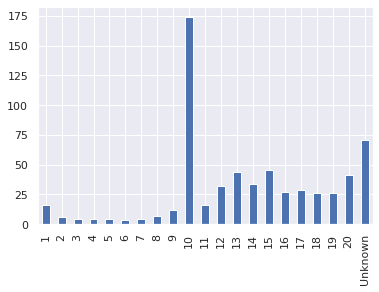

In [38]:
d20rolls.loc[is_reliable_talent, 'Natural Value'].value_counts()[[str(i) for i in range(1, 21)] + ['Unknown']].plot.bar()

In [42]:
 d20rolls.loc[mask_straight
              & ~is_natval_known
              & ~is_reliable_talent
              , 'Notes'
             ].dropna()

52                                                     Gestures for bad roll, no number
102                          Trapping Arrow, Includes inspiration die, amount not given
125                                                                   Pepperbox Misfire
141                                                                               Arrow
174                                                                              Dagger
240                                                                   Bad News, Misfire
241                                                                               Arrow
269                                                                                 Bad
270                                                                                 Bad
374                                                        Firebolt with Metamagic Wand
385                                                                     worse than a 9!
406                             